# LIBRARIES

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

# DATA LOAD

In [44]:
!pip install split-folders
import splitfolders
splitfolders.ratio('../input/alzheimer-mri-dataset/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1)) 

Copying files: 6400 files [00:06, 1063.57 files/s]


In [45]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123, label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,label_mode='categorical',
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [46]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset shapes: ((None, 128, 128, 3), (None, 4)), types: (tf.float32, tf.float32)>

# EXAMPLE IMAGE

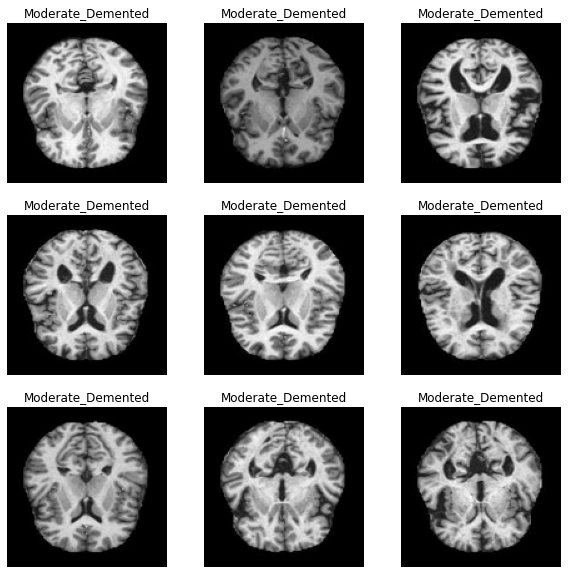

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis("off")
        
        


<function matplotlib.pyplot.show(close=None, block=None)>

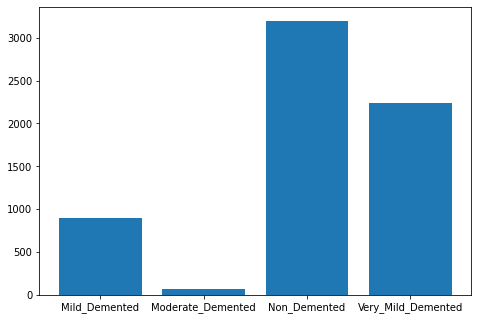

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

# MODEL

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(32,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [50]:
model.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=['accuracy',
                                tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [51]:
filepath = './cnn_best_weights.hdf5'
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              patience=10,
                                              verbose=1)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True,
                           verbose=1)

callbacks_list=[earlystopping,checkpoint]

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)       

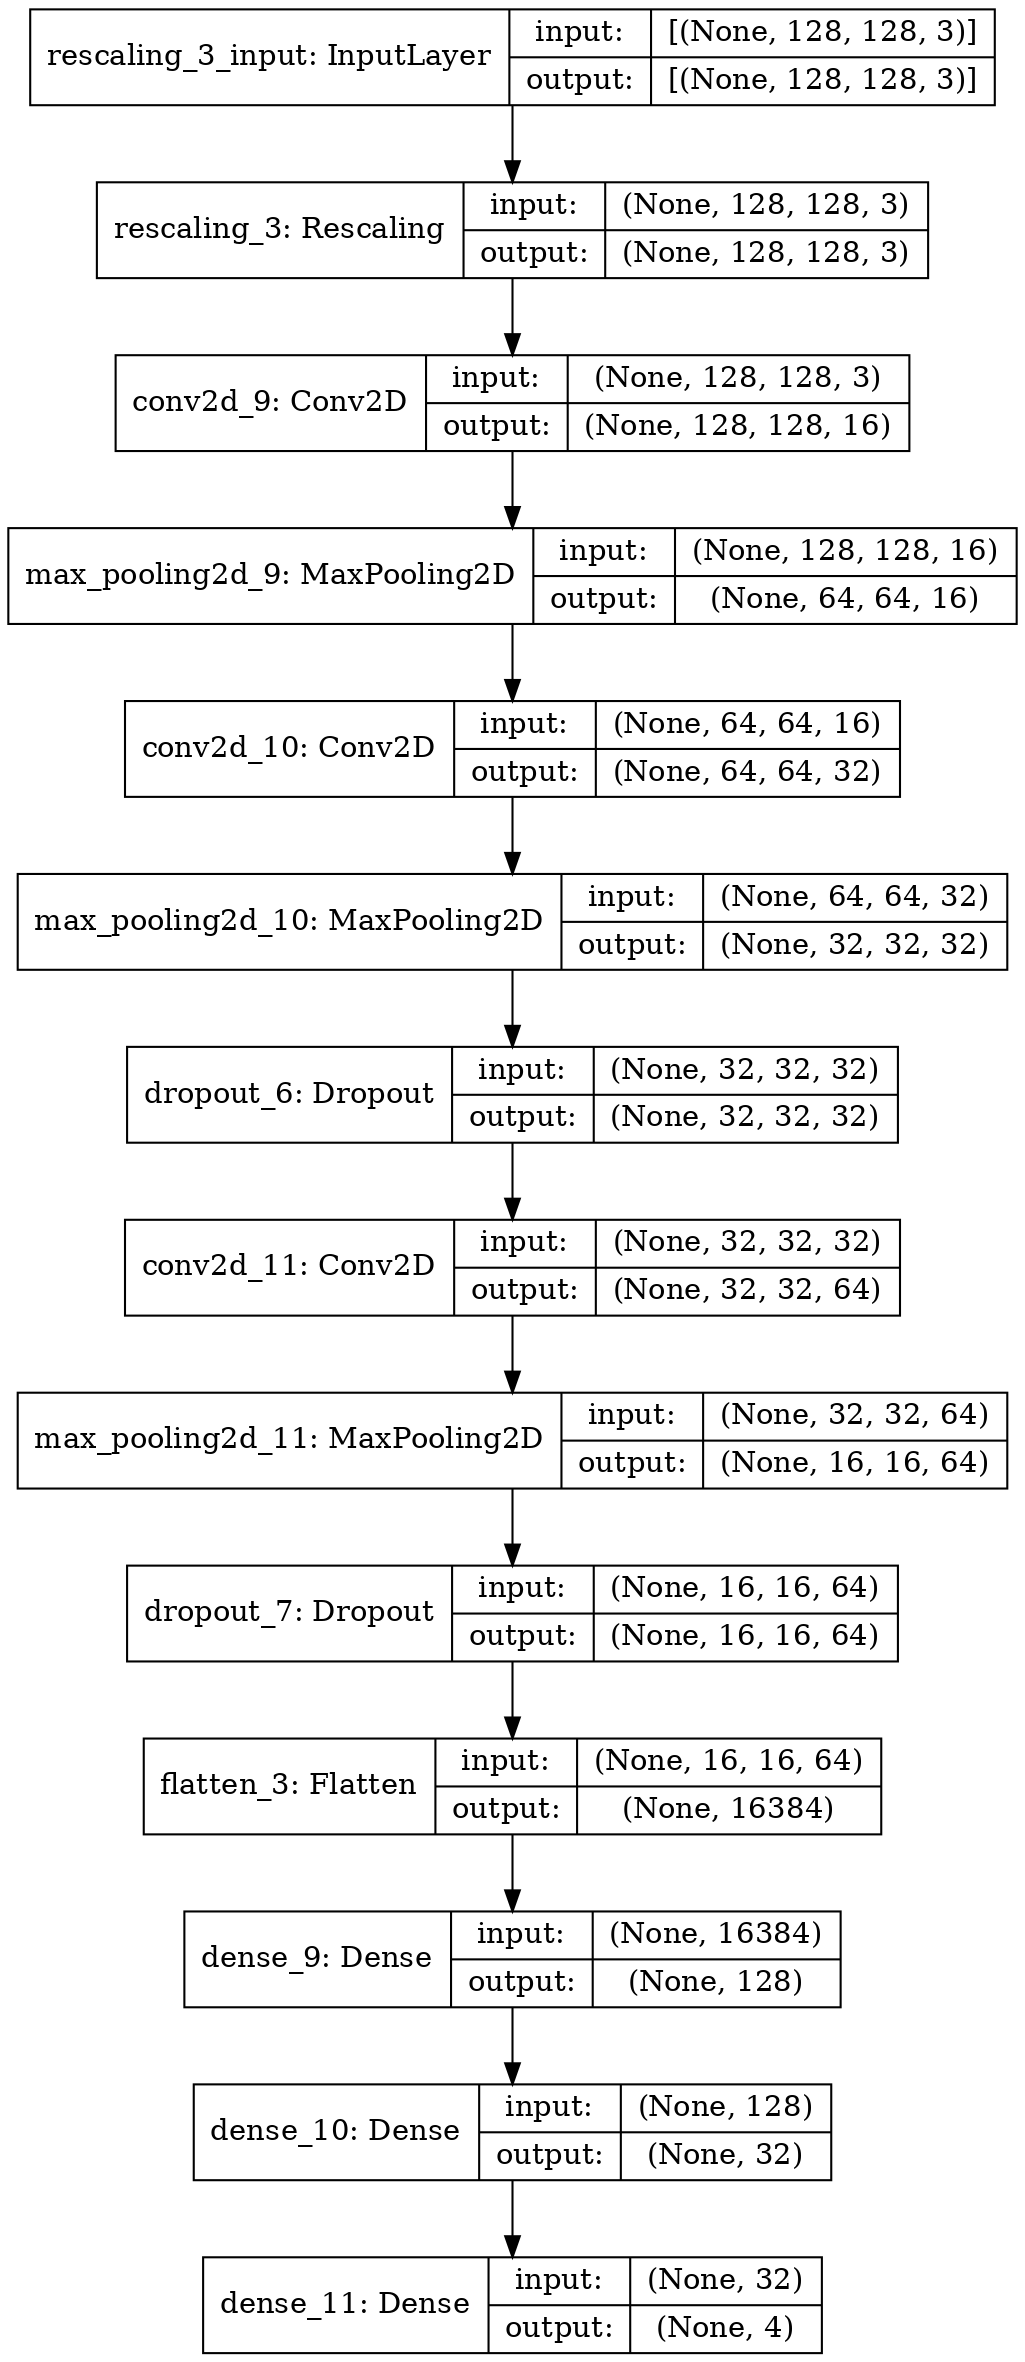

In [53]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=150)

In [54]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1,
                 callbacks= callbacks_list, use_multiprocessing=True)

Epoch 1/50
80/80 [==============================] - 4s 35ms/step - loss: 1.2578 - accuracy: 0.4882 - auc_3: 0.7776 - precision_3: 0.5483 - recall_3: 0.3192 - val_loss: 1.0635 - val_accuracy: 0.5070 - val_auc_3: 0.8334 - val_precision_3: 1.0000 - val_recall_3: 0.0156

Epoch 00001: val_accuracy improved from -inf to 0.50704, saving model to ./cnn_best_weights.hdf5
Epoch 2/50
80/80 [==============================] - 2s 27ms/step - loss: 0.9551 - accuracy: 0.5511 - auc_3: 0.8300 - precision_3: 0.6490 - recall_3: 0.3778 - val_loss: 0.9449 - val_accuracy: 0.5869 - val_auc_3: 0.8549 - val_precision_3: 0.7717 - val_recall_3: 0.3333

Epoch 00002: val_accuracy improved from 0.50704 to 0.58685, saving model to ./cnn_best_weights.hdf5
Epoch 3/50
80/80 [==============================] - 2s 26ms/step - loss: 0.9030 - accuracy: 0.5847 - auc_3: 0.8478 - precision_3: 0.6624 - recall_3: 0.4366 - val_loss: 0.8608 - val_accuracy: 0.6432 - val_auc_3: 0.8776 - val_precision_3: 0.7667 - val_recall_3: 0.3959


# Plot the result


In [55]:
result = model.evaluate(test_ds)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Test Loss = {train_loss}')
print(f'Test Accuracy = {train_accuracy}')
print(f'Test AUC = {train_AUC}')
print(f'Test Precision = {train_pre}')
print(f'Test Recall = {train_rec}')

11/11 [==============================] - 0s 12ms/step - loss: 0.0352 - accuracy: 0.9907 - auc_3: 0.9997 - precision_3: 0.9907 - recall_3: 0.9907
Test Loss = 0.035189464688301086
Test Accuracy = 0.9906542301177979
Test AUC = 0.9997194409370422
Test Precision = 0.9906542301177979
Test Recall = 0.9906542301177979


In [58]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
get_pre = hist.history['precision_3']
get_rec = hist.history['recall_3']
get_auc = hist.history['auc_3']

val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

<Figure size 432x288 with 0 Axes>

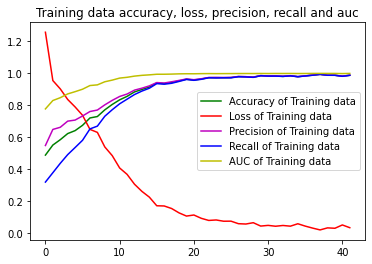

<Figure size 432x288 with 0 Axes>

In [59]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.plot(epochs, get_pre, 'm', label='Precision of Training data')
plt.plot(epochs, get_rec, 'b', label='Recall of Training data')
plt.plot(epochs, get_auc, 'y', label='AUC of Training data')

plt.title('Training data accuracy, loss, precision, recall and auc')
plt.legend(loc=0)
plt.figure()

# plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
# plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
# plt.title('Training and Validation Accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
# plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
# plt.title('Training and Validation Loss')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

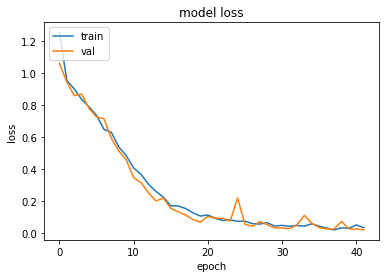

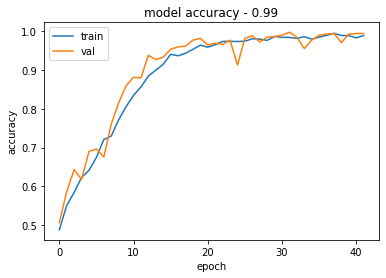

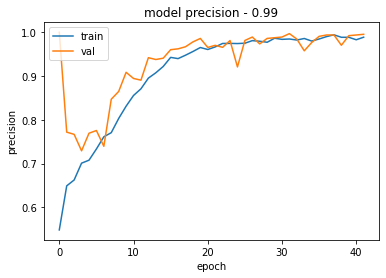

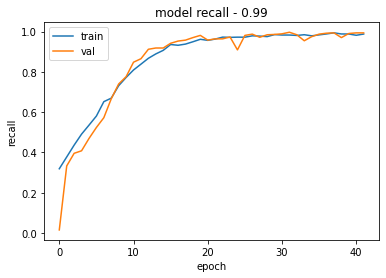

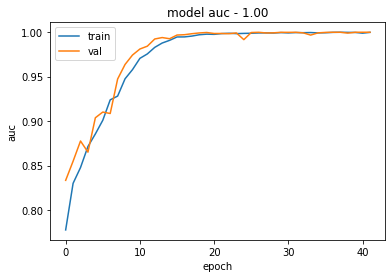

In [60]:
# loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Precision
plt.plot(hist.history['precision_3'])
plt.plot(hist.history['val_precision_3'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Recall
plt.plot(hist.history['recall_3'])
plt.plot(hist.history['val_recall_3'])
plt.title('model recall - ' + str(format(result[4], "0.2f")))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# AUC
plt.plot(hist.history['auc_3'])
plt.plot(hist.history['val_auc_3'])
plt.title('model auc - ' + str(format(result[2], "0.2f")))
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Confusion Matrix

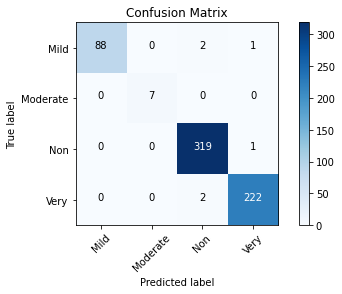

In [61]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()